# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM-win48'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 48

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18781, 18119)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 6])

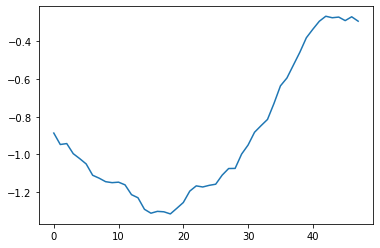

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 32, 9, padding=4),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Conv1d(32, 64, 9, padding=4),
            nn.BatchNorm1d(64),
        )

        self.rnn = nn.LSTM(input_size=64,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=6, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  18.741470
 - Pitch        :  10.322814
 - Roll         :   2.553602
 - RMS          :  12.440847
 - 99% Tile     :  43.550283
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  14.596718
 - Pitch        :   9.304841
 - Roll         :   2.420126
 - RMS          :  10.091271
 - 99% Tile     :  38.177817
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  11.547221
 - Pitch        :   8.477911
 - Roll         :   2.360176
 - RMS          :   8.382197
 - 99% Tile     :  33.535596
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.651555
 - Pitch        :   7.748212
 - Roll         :   2.382820
 - RMS          :   7.277021
 - 99% Tile     :  29.939513
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.414256
 - Pitch        :   7.159812
 - Roll         :   2.390695
 - RMS          :   6.526307
 - 99% Tile     :  26.900660
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.123420
 - Pitch        :   7.237518
 - Roll         :   2.378676
 - RMS          :   6.021708
 - 99% Tile     :  25.252621
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.921609
 - Pitch        :   7.180303
 - Roll         :   2.347164
 - RMS          :   5.541702
 - 99% Tile     :  23.540656
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.522880
 - Pitch        :   6.684819
 - Roll         :   2.348116
 - RMS          :   5.186606
 - 99% Tile     :  21.675157
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.249418
 - Pitch        :   6.952135
 - Roll         :   2.365036
 - RMS          :   4.898406
 - 99% Tile     :  22.108945
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.286305
 - Pitch        :   6.457706
 - Roll         :   2.345553
 - RMS          :   4.675325
 - 99% Tile     :  21.196930
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.552262
 - Pitch        :   6.557030
 - Roll         :   2.313385
 - RMS          :   4.507954
 - 99% Tile     :  20.554684
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.478740
 - Pitch        :   6.337267
 - Roll         :   2.306404
 - RMS          :   4.381099
 - 99% Tile     :  19.864337
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   6.070048
 - Pitch        :   6.507560
 - Roll         :   2.294393
 - RMS          :   5.305911
 - 99% Tile     :  28.697361
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   3.429643
 - Pitch        :   6.407864
 - Roll         :   2.245177
 - RMS          :   4.391810
 - 99% Tile     :  20.221886
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.930336
 - Pitch        :   6.293635
 - Roll         :   2.298648
 - RMS          :   4.222184
 - 99% Tile     :  19.570653
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.045676
 - Pitch        :   6.192912
 - Roll         :   2.314479
 - RMS          :   4.202583
 - 99% Tile     :  19.469114
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.034515
 - Pitch        :   6.064307
 - Roll         :   2.336569
 - RMS          :   4.141000
 - 99% Tile     :  19.606613
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.924109
 - Pitch        :   6.145806
 - Roll         :   2.333309
 - RMS          :   4.153941
 - 99% Tile     :  19.522169
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.948281
 - Pitch        :   6.081635
 - Roll         :   2.317464
 - RMS          :   4.125097
 - 99% Tile     :  19.647430
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   2.983460
 - Pitch        :   6.083443
 - Roll         :   2.309419
 - RMS          :   4.132905
 - 99% Tile     :  19.819198
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.962034
 - Pitch        :   5.935708
 - Roll         :   2.344042
 - RMS          :   4.062053
 - 99% Tile     :  19.679989
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.677517
 - Pitch        :   6.485047
 - Roll         :   2.360797
 - RMS          :   4.514914
 - 99% Tile     :  22.167858
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.665481
 - Pitch        :   6.176372
 - Roll         :   2.309101
 - RMS          :   4.106268
 - 99% Tile     :  19.989214
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.631604
 - Pitch        :   6.093563
 - Roll         :   2.317207
 - RMS          :   4.058994
 - 99% Tile     :  20.098766
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.755399
 - Pitch        :   5.990181
 - Roll         :   2.316038
 - RMS          :   4.034787
 - 99% Tile     :  19.921750
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.771437
 - Pitch        :   6.062458
 - Roll         :   2.287219
 - RMS          :   4.068809
 - 99% Tile     :  19.705083
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.420056
 - Pitch        :   6.002973
 - Roll         :   2.317384
 - RMS          :   3.969157
 - 99% Tile     :  20.300619
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.961272
 - Pitch        :   5.934949
 - Roll         :   2.319242
 - RMS          :   4.056748
 - 99% Tile     :  20.374609
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   3.616329
 - Pitch        :   5.917207
 - Roll         :   2.335934
 - RMS          :   4.224838
 - 99% Tile     :  19.908648
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   3.597158
 - Pitch        :   5.993666
 - Roll         :   2.352694
 - RMS          :   4.258276
 - 99% Tile     :  20.373804
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   2.858723
 - Pitch        :   6.147653
 - Roll         :   2.292778
 - RMS          :   4.132101
 - 99% Tile     :  21.515387
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   2.985336
 - Pitch        :   5.844554
 - Roll         :   2.305117
 - RMS          :   4.015993
 - 99% Tile     :  18.914950
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   2.675001
 - Pitch        :   5.984231
 - Roll         :   2.319732
 - RMS          :   4.014466
 - 99% Tile     :  20.693001
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.586200
 - Pitch        :   5.347366
 - Roll         :   2.325115
 - RMS          :   3.682794
 - 99% Tile     :  19.469408
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   4.177138
 - Pitch        :   5.058820
 - Roll         :   2.346757
 - RMS          :   4.022744
 - 99% Tile     :  18.993517
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.373602
 - Pitch        :   4.160264
 - Roll         :   2.310591
 - RMS          :   3.070321
 - 99% Tile     :  17.082427
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.960800
 - Pitch        :   4.142386
 - Roll         :   2.325512
 - RMS          :   3.231806
 - 99% Tile     :  17.478733
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.379352
 - Pitch        :   3.596884
 - Roll         :   2.319544
 - RMS          :   2.827200
 - 99% Tile     :  14.851099
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.686154
 - Pitch        :   4.010361
 - Roll         :   2.293226
 - RMS          :   3.412214
 - 99% Tile     :  17.562386
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.625748
 - Pitch        :   3.162503
 - Roll         :   2.297263
 - RMS          :   2.718663
 - 99% Tile     :  14.738822
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.154722
 - Pitch        :   2.753553
 - Roll         :   2.284188
 - RMS          :   2.411251
 - 99% Tile     :  12.534565
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.801281
 - Pitch        :   2.463323
 - Roll         :   2.297468
 - RMS          :   2.205367
 - 99% Tile     :  11.866633
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.758288
 - Pitch        :   2.483123
 - Roll         :   2.210871
 - RMS          :   2.171438
 - 99% Tile     :  11.577176
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.792635
 - Pitch        :   2.045374
 - Roll         :   2.230273
 - RMS          :   2.030699
 - 99% Tile     :  11.021274
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.534613
 - Pitch        :   2.246724
 - Roll         :   2.229671
 - RMS          :   2.030947
 - 99% Tile     :  10.426224
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.064270
 - Pitch        :   1.994685
 - Roll         :   2.196491
 - RMS          :   2.086828
 - 99% Tile     :  10.848265
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.558756
 - Pitch        :   2.341578
 - Roll         :   2.177926
 - RMS          :   2.053945
 - 99% Tile     :   9.878286
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.980680
 - Pitch        :   1.877215
 - Roll         :   2.208096
 - RMS          :   2.026715
 - 99% Tile     :   9.831652
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.548569
 - Pitch        :   2.044834
 - Roll         :   2.148321
 - RMS          :   1.931726
 - 99% Tile     :   9.950045
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   2.174184
 - Pitch        :   1.887997
 - Roll         :   2.249123
 - RMS          :   2.109515
 - 99% Tile     :  11.337106
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.635414
 - Pitch        :   1.685606
 - Roll         :   2.225566
 - RMS          :   1.868064
 - 99% Tile     :  10.523725
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.524509
 - Pitch        :   1.593370
 - Roll         :   2.216624
 - RMS          :   1.805212
 - 99% Tile     :   9.574401
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.872717
 - Pitch        :   1.602254
 - Roll         :   2.205323
 - RMS          :   1.909428
 - 99% Tile     :   9.741246
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.526535
 - Pitch        :   1.582777
 - Roll         :   2.191323
 - RMS          :   1.792334
 - 99% Tile     :   9.601750
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.503262
 - Pitch        :   2.278411
 - Roll         :   2.140963
 - RMS          :   2.002888
 - 99% Tile     :   9.510080
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.396292
 - Pitch        :   1.634349
 - Roll         :   2.168541
 - RMS          :   1.762885
 - 99% Tile     :   9.030087
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.298258
 - Pitch        :   1.486044
 - Roll         :   2.160645
 - RMS          :   1.689397
 - 99% Tile     :   9.099840
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.737826
 - Pitch        :   2.051944
 - Roll         :   2.182115
 - RMS          :   1.999345
 - 99% Tile     :   9.961128
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.521355
 - Pitch        :   1.899801
 - Roll         :   2.133792
 - RMS          :   1.868764
 - 99% Tile     :   9.043766
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   3.600925
 - Pitch        :   2.236399
 - Roll         :   2.315676
 - RMS          :   2.788697
 - 99% Tile     :  14.039281
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   2.286046
 - Pitch        :   1.533816
 - Roll         :   2.159316
 - RMS          :   2.020003
 - 99% Tile     :  10.832712
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.864087
 - Pitch        :   1.546477
 - Roll         :   2.146059
 - RMS          :   1.868331
 - 99% Tile     :   9.844033
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.772154
 - Pitch        :   1.462034
 - Roll         :   2.145411
 - RMS          :   1.814833
 - 99% Tile     :   9.763947
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.602022
 - Pitch        :   1.432562
 - Roll         :   2.166421
 - RMS          :   1.761826
 - 99% Tile     :   9.089765
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.341604
 - Pitch        :   1.347889
 - Roll         :   2.174260
 - RMS          :   1.667744
 - 99% Tile     :   9.022695
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.288195
 - Pitch        :   1.329585
 - Roll         :   2.179762
 - RMS          :   1.651121
 - 99% Tile     :   9.044660
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.386217
 - Pitch        :   1.491161
 - Roll         :   2.153899
 - RMS          :   1.711183
 - 99% Tile     :   8.951109
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.374871
 - Pitch        :   1.376752
 - Roll         :   2.151542
 - RMS          :   1.674798
 - 99% Tile     :   8.817292
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.350757
 - Pitch        :   1.377442
 - Roll         :   2.154273
 - RMS          :   1.669609
 - 99% Tile     :   8.945776
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.344628
 - Pitch        :   1.298977
 - Roll         :   2.159462
 - RMS          :   1.649105
 - 99% Tile     :   8.780958
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.366280
 - Pitch        :   1.326647
 - Roll         :   2.134648
 - RMS          :   1.651609
 - 99% Tile     :   8.796411
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.254473
 - Pitch        :   1.356860
 - Roll         :   2.149946
 - RMS          :   1.636769
 - 99% Tile     :   8.773899
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.270325
 - Pitch        :   1.313467
 - Roll         :   2.127882
 - RMS          :   1.619341
 - 99% Tile     :   8.506981
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.322158
 - Pitch        :   1.409554
 - Roll         :   2.119609
 - RMS          :   1.656068
 - 99% Tile     :   8.585579
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.351350
 - Pitch        :   1.411641
 - Roll         :   2.133138
 - RMS          :   1.670245
 - 99% Tile     :   8.708549
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.247146
 - Pitch        :   1.478063
 - Roll         :   2.127840
 - RMS          :   1.660095
 - 99% Tile     :   8.493988
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.195619
 - Pitch        :   1.322288
 - Roll         :   2.116330
 - RMS          :   1.597582
 - 99% Tile     :   8.424565
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.398854
 - Pitch        :   1.256161
 - Roll         :   2.146984
 - RMS          :   1.647652
 - 99% Tile     :   8.408877
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.329777
 - Pitch        :   1.228770
 - Roll         :   2.130917
 - RMS          :   1.614413
 - 99% Tile     :   8.424922
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.178055
 - Pitch        :   1.422246
 - Roll         :   2.134601
 - RMS          :   1.629634
 - 99% Tile     :   8.383270
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0080.npy


[0082/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.357222
 - Pitch        :   1.432804
 - Roll         :   2.131102
 - RMS          :   1.676959
 - 99% Tile     :   8.364886
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0081.npy


[0083/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.134848
 - Pitch        :   1.183800
 - Roll         :   2.138304
 - RMS          :   1.555807
 - 99% Tile     :   8.330046
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0082.npy


[0084/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.234552
 - Pitch        :   1.483475
 - Roll         :   2.084761
 - RMS          :   1.640228
 - 99% Tile     :   8.266077
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0083.npy


[0085/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.192588
 - Pitch        :   1.330748
 - Roll         :   2.135279
 - RMS          :   1.607542
 - 99% Tile     :   8.203660
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0084.npy


[0086/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.155294
 - Pitch        :   1.556885
 - Roll         :   2.110892
 - RMS          :   1.654737
 - 99% Tile     :   8.209268
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0085.npy


[0087/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.207830
 - Pitch        :   1.289830
 - Roll         :   2.118059
 - RMS          :   1.592554
 - 99% Tile     :   8.135980
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0086.npy


[0088/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.288112
 - Pitch        :   1.307623
 - Roll         :   2.099695
 - RMS          :   1.610159
 - 99% Tile     :   8.142975
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0087.npy


[0089/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.098874
 - Pitch        :   1.276960
 - Roll         :   2.094873
 - RMS          :   1.552057
 - 99% Tile     :   8.105162
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0088.npy


[0090/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.250244
 - Pitch        :   1.264019
 - Roll         :   2.113065
 - RMS          :   1.594354
 - 99% Tile     :   8.233869
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0089.npy


[0091/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.127280
 - Pitch        :   1.248285
 - Roll         :   2.094704
 - RMS          :   1.550996
 - 99% Tile     :   8.103364
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0090.npy


[0092/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.106465
 - Pitch        :   1.185015
 - Roll         :   2.100255
 - RMS          :   1.531840
 - 99% Tile     :   8.097431
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0091.npy


[0093/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.179269
 - Pitch        :   1.262529
 - Roll         :   2.071635
 - RMS          :   1.557383
 - 99% Tile     :   8.066432
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0092.npy


[0094/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.093018
 - Pitch        :   1.270419
 - Roll         :   2.073269
 - RMS          :   1.539166
 - 99% Tile     :   8.007242
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0093.npy


[0095/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.206170
 - Pitch        :   1.302018
 - Roll         :   2.058034
 - RMS          :   1.569034
 - 99% Tile     :   8.069478
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0094.npy


[0096/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.142965
 - Pitch        :   1.150895
 - Roll         :   2.066824
 - RMS          :   1.516871
 - 99% Tile     :   8.017251
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0095.npy


[0097/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.108090
 - Pitch        :   1.220006
 - Roll         :   2.052321
 - RMS          :   1.519682
 - 99% Tile     :   7.992359
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0096.npy


[0098/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.363448
 - Pitch        :   1.320478
 - Roll         :   2.050240
 - RMS          :   1.613086
 - 99% Tile     :   8.554258
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0097.npy


[0099/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.210642
 - Pitch        :   1.150865
 - Roll         :   2.039604
 - RMS          :   1.522074
 - 99% Tile     :   8.339088
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0098.npy


[0100/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.289318
 - Pitch        :   1.119965
 - Roll         :   2.036093
 - RMS          :   1.534312
 - 99% Tile     :   8.277029
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0099.npy


[0100/0100] Validation: 100%|██████████████████████| 71/71 [00:02<00:00, 32.77it/s, val_loss 5.4384]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.180215
 - Pitch        :   1.165746
 - Roll         :   2.005607
 - RMS          :   1.502701
 - 99% Tile     :   8.274912
Save output signals into checkpoint/1122-Scene3-CLSTM-win48/sample/0100.npy
